## DLCV Sprint 2018 HW1
### d05921018 林家慶

In [1]:
import glob
import re
import numpy as np
import skimage
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
from sklearn.decomposition import PCA

## Problem 1

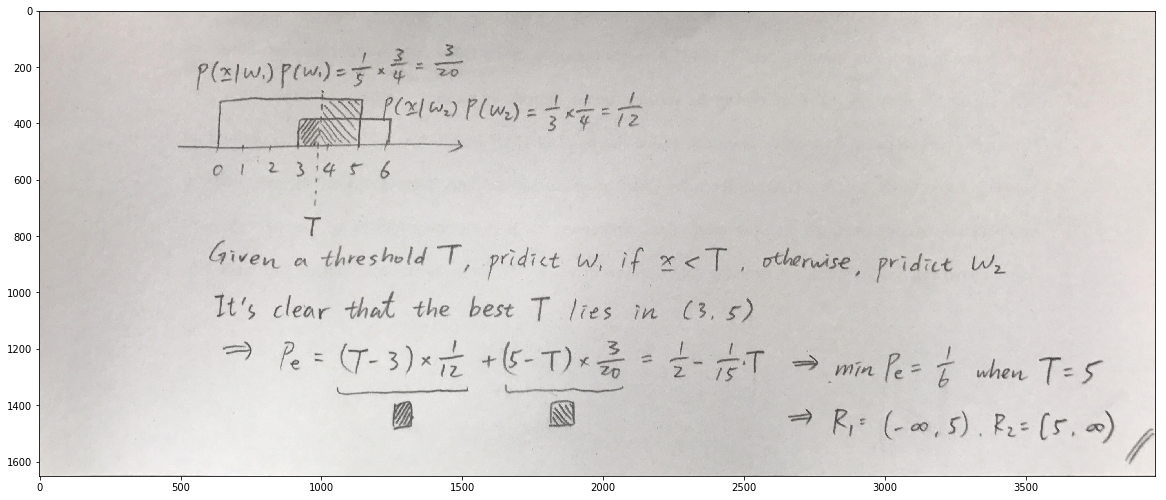

In [2]:
prob1 = skimage.io.imread("hw1_1.jpg")
plt.figure(figsize=(20,20))
plt.imshow(prob1)

## Problem 2

### Split Training/Testing

In [3]:
file_path = '/data/put_data/cclin/ntu/dlcv2018/hw1/hw1_dataset/'
file_all = glob.glob(file_path + '*.png')
print('Total images: %d' % len(file_all))

## Training set contains the first 6 images of each subject
### (1) start from 1_1.png, 1_2.png, ...
file_train = []
for i in range(1,41):
    for j in range(1,7):
        file_train.append(file_path+str(i)+'_'+str(j)+'.png')
### (2) start from 40_6.png, 40_5.png, ...
# file_train = []
# for i in range(40,0,-1):
#     for j in range(6,0,-1):
#         file_train.append(file_path+str(i)+'_'+str(j)+'.png')
### (3) random order
# file_train = [file for file in file_all if int(re.search('[0-9]+_([0-9]+)', file).group(1)) < 7]
print('Training images: %d' % len(file_train))

## Testing set contains the rests
### (1) start from 1_7.png, 1_8.png, ...
file_test = []
for i in range(1,41):
    for j in range(7,11):
        file_test.append(file_path+str(i)+'_'+str(j)+'.png')
### (2) start from 40_10.png, 40_9.png, ...
# file_test = []
# for i in range(40,0,-1):
#     for j in range(10,6,-1):
#         file_test.append(file_path+str(i)+'_'+str(j)+'.png')
### (3) random order
# file_test = [file for file in file_all if not file in file_train]
print('Testing images: %d' % len(file_test))

Total images: 400
Training images: 240
Testing images: 160


### Read images and labels

In [4]:
# Training
train_x = np.array([skimage.io.imread(file) for file in file_train])
print('Before reshape, train_x.shape = %s' % str(train_x.shape))
## Reshape
train_x = train_x.reshape([train_x.shape[0], train_x.shape[1]*train_x.shape[2]])
print('After reshape, train_x.shape = %s' % str(train_x.shape))
train_y = np.array([int(re.search('([0-9]+)_[0-9]+', file).group(1)) for file in file_train])
print('train_y.shape = %s' % str(train_y.shape))

# Testing
test_x = np.array([skimage.io.imread(file) for file in file_test])
print('Before reshape, test_x.shape = %s' % str(test_x.shape))
## Reshape
test_x = test_x.reshape([test_x.shape[0], test_x.shape[1]*test_x.shape[2]])
print('Before reshape, test_x.shape = %s' % str(test_x.shape))
test_y = np.array([int(re.search('([0-9]+)_[0-9]+', file).group(1)) for file in file_test])
print('test_y.shape = %s' % str(test_y.shape))

Before reshape, train_x.shape = (240, 56, 46)
After reshape, train_x.shape = (240, 2576)
train_y.shape = (240,)
Before reshape, test_x.shape = (160, 56, 46)
Before reshape, test_x.shape = (160, 2576)
test_y.shape = (160,)


### PCA

In [5]:
## Normalization
train_x_norm = train_x.copy().astype('float64')
train_x_mean = train_x.mean(axis = 0)
for idx in range(train_x_norm.shape[0]):
    train_x_norm[idx] -= train_x_mean

# if n_components is not set, all components are kept,
# i.e., n_components == min(n_samples, n_features)
pca = PCA()
pca.fit(train_x - train_x_mean)
print(pca.explained_variance_[0:3]) ## eigenvalues
print(pca.explained_variance_ratio_[0:3]) ## eigenvalue proportions (sum to 1)
print(pca.components_[0:3]) ## eigenvectors

[738488.32723728 514671.51424459 284193.06403729]
[0.19458392 0.13561054 0.07488189]
[[-0.00814755 -0.0082819  -0.00762469 ... -0.01342091 -0.01139615
  -0.0120333 ]
 [-0.02879244 -0.02883591 -0.02911945 ...  0.01501812  0.02029234
   0.01911738]
 [ 0.04038878  0.04010287  0.04029472 ...  0.01752608  0.02245861
   0.02438696]]


#### (a) The mean face and the first three eigenfaces

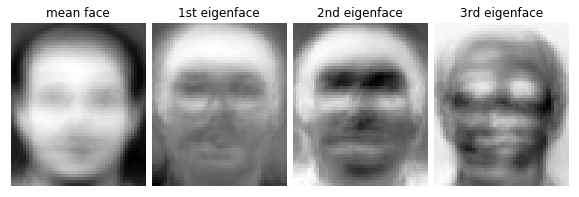

In [6]:
temp_titles = ['mean face', '1st eigenface', '2nd eigenface', '3rd eigenface']
eigen_faces = [train_x_mean]
for idx in range(3):
    eigen_faces.append(pca.components_[idx])

## Plot
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, len(eigen_faces))
gs.update(wspace=0.05, hspace=0.05)
for idx in range(len(eigen_faces)):
    ax = plt.subplot(gs[idx])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    ax.set_title(temp_titles[idx])
    plt.imshow(eigen_faces[idx].reshape([56, 46]), cmap='Greys_r')

#### (b) Original and reconstructed images

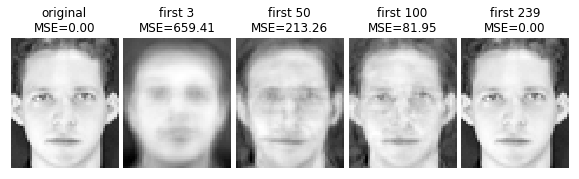

In [7]:
## Take 1_1.png
face_1_1 = skimage.io.imread(file_path + '1_1.png')

## Extract a_i's for all i = 0, 1, ..., 239
face_1_1_loading = (face_1_1.reshape([56*46]) - train_x_mean).dot(pca.components_.T)

## Projection
face_1_1_rec = [face_1_1.reshape([56*46])]
mse_1_1_rec = [0]
for n_dim in [3,50,100,239]:
    rec = pca.components_[0]*face_1_1_loading[0]
    for dim_idx in range(1,n_dim):
        rec += pca.components_[dim_idx]*face_1_1_loading[dim_idx]
    rec += train_x_mean
    face_1_1_rec.append(rec)
    ## compute mean square error
    mse = ((rec - face_1_1.reshape([56*46]))**2).mean()
    mse_1_1_rec.append(mse)

## Plot
temp_titles = ['original', 'first 3', 'first 50', 'first 100', 'first 239']
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(1, len(face_1_1_rec))
gs.update(wspace=0.05, hspace=0.05)
for idx in range(len(face_1_1_rec)):
    ax = plt.subplot(gs[idx])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    ax.set_title('%s\nMSE=%.2f'%(str(temp_titles[idx]), mse_1_1_rec[idx]))
    plt.imshow(face_1_1_rec[idx].reshape([56, 46]), cmap='Greys_r')

#### (c) KNN

In [8]:
from sklearn.neighbors import KNeighborsClassifier

#### approach 1: cross_val_score

In [9]:
from sklearn.model_selection import cross_val_score

k_list = [1,3,5]
n_list = [3,50,159]
print('Average validation accuracy (+/- 2 std):')
for k in k_list:
    for n in n_list:
        neigh = KNeighborsClassifier(n_neighbors=k)
        feature_x = pca.transform(train_x - train_x_mean)[:,0:n]
        scores = cross_val_score(neigh, feature_x, train_y, cv=3)
        print('[k = %d, n = %d] ' % (k, n), end = '')
        print('%.4f (+/- %.4f)' % (scores.mean(), scores.std() * 2))

Average validation accuracy (+/- 2 std):
[k = 1, n = 3] 0.7083 (+/- 0.0656)
[k = 1, n = 50] 0.9292 (+/- 0.0118)
[k = 1, n = 159] 0.9250 (+/- 0.0204)
[k = 3, n = 3] 0.5875 (+/- 0.0890)
[k = 3, n = 50] 0.8750 (+/- 0.0540)
[k = 3, n = 159] 0.8708 (+/- 0.0656)
[k = 5, n = 3] 0.4875 (+/- 0.1871)
[k = 5, n = 50] 0.7750 (+/- 0.0612)
[k = 5, n = 159] 0.7458 (+/- 0.0514)


Based on the results above, (k, n) = (1, 50) seems to be the best choice. 

#### approach 2: GridSearchCV

In [10]:
from sklearn.model_selection import GridSearchCV

k_list = [1,3,5]
n_list = [3,50,159]
params = {'n_neighbors':[1,3,5]}
kNN = KNeighborsClassifier()
clf = GridSearchCV(kNN, params,cv=3)
for n in n_list:
    feature_x = pca.transform(train_x - train_x_mean)[:,0:n]
    print("n:",n)
    clf.fit(feature_x, train_y)
    print(clf.cv_results_["mean_test_score"])

n: 3
[0.70833333 0.5875     0.4875    ]
n: 50
[0.92916667 0.875      0.775     ]
n: 159
[0.925      0.87083333 0.74583333]


Again, (k, n) = (1, 50) seems to be the best choice. 

#### Recognition rate on the test set

In [11]:
neigh = KNeighborsClassifier(n_neighbors=1)
feature_x = pca.transform(train_x - train_x_mean)[:,0:50]
neigh.fit(feature_x, train_y)
feature_x_test = pca.transform(test_x - train_x_mean)[:,0:50]
test_y_pred = neigh.predict(feature_x_test)
accuracy = sum(test_y_pred == test_y) / len(test_y)
print('The the recognition accuracy on the test set is %f' % accuracy)

The the recognition accuracy on the test set is 0.962500
